<a href="https://colab.research.google.com/github/gustavovazquez/ML/blob/main/ML_Redes_Neuronales_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Caso de uso: predicción de precios vivienda


El set de datos SaratogaHouses del paquete mosaicData de R contiene información sobre el precio de 1728 viviendas situadas en Saratoga County, New York, USA en el año 2006. Además del precio, incluye 15 variables adicionales:

- price: precio de la vivienda.
- lotSize: metros cuadrados de la vivienda.
- age: antigüedad de la vivienda.
- landValue: valor del terreno.
- livingArea: metros cuadrados habitables.
- pctCollege: porcentaje del vecindario con título universitario.
- bedrooms: número de dormitorios.
- firplaces: número de chimeneas.
- bathrooms: número de baños (el valor 0.5 hace referencia a baños sin ducha).
- rooms: número de habitaciones.
- heating: tipo de calefacción.
- fuel: tipo de alimentación de la calefacción (gas, electricidad o diesel).
- sewer: tipo de desagüe.
- waterfront: si la vivienda tiene vistas al lago.
- newConstruction: si la vivienda es de construcción nueva.
- centralAir: si la vivienda tiene aire acondicionado central.

El objetivo es obtener un modelo capaz de predecir el precio del alquiler.

##Librerías

In [ ]:
# Tratamiento de datos

import numpy as np
import pandas as pd

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#plt.style.use('dark_background')

# Modelado
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
import math

## Carga de datos

In [ ]:
# Descarga de datos

url = ("https://github.com/gustavovazquez/datasets/raw/main/SaratogaHouses.csv")

datos = pd.read_csv(url)
datos.head()


,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes


In [ ]:
# mostrar los nombres de las columnas del dataframe
datos.columns


Index(['price', 'lotSize', 'age', 'landValue', 'livingArea', 'pctCollege',
       'bedrooms', 'fireplaces', 'bathrooms', 'rooms', 'heating', 'fuel',
       'sewer', 'waterfront', 'newConstruction', 'centralAir'],
      dtype='object')

En este punto podemos dejar los nombres originales de las columnas, pero consideramos mejor renombrarlos para que sea más fácil su uso

In [ ]:
datos.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno",
                 "metros_habitables", "universitarios", "dormitorios",
                 "chimenea", "banyos", "habitaciones", "calefaccion",
                 "consumo_calefacion", "desague", "vistas_lago",
                 "nueva_construccion", "aire_acondicionado"]

#Análisis exploratorio


Antes de entrenar un modelo predictivo, o incluso antes de realizar cualquier cálculo con un nuevo conjunto de datos, es muy importante realizar una exploración descriptiva de los mismos. Este proceso permite entender mejor qué información contiene cada variable, así como detectar posibles errores. Algunos ejemplos frecuentes son:

- Que una columna se haya almacenado con el tipo incorrecto: una variable numérica está siendo reconocida como texto o viceversa.

- Que una variable contenga valores que no tienen sentido: por ejemplo, para indicar que no se dispone del precio de una vivienda se introduce el valor 0 o un espacio en blanco.

- Que en una variable de tipo numérico se haya introducido una palabra en lugar de un número.

Esta no es una lista exhaustiva de las posibles situaciones, de modo que deberá usarse el criterio personal y el entendimiento del negocio.

Además, este análisis inicial puede dar pistas sobre qué variables son adecuadas como predictores en un modelo.


In [ ]:
# Tipo de cada columna
# En pandas, el tipo "object" hace referencia a los strings que indican los valores de cada clase en las variables categóricas
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   precio              1728 non-null   int64  
 1   metros_totales      1728 non-null   float64
 2   antiguedad          1728 non-null   int64  
 3   precio_terreno      1728 non-null   int64  
 4   metros_habitables   1728 non-null   int64  
 5   universitarios      1728 non-null   int64  
 6   dormitorios         1728 non-null   int64  
 7   chimenea            1728 non-null   int64  
 8   banyos              1728 non-null   float64
 9   habitaciones        1728 non-null   int64  
 10  calefaccion         1728 non-null   object 
 11  consumo_calefacion  1728 non-null   object 
 12  desague             1728 non-null   object 
 13  vistas_lago         1728 non-null   object 
 14  nueva_construccion  1728 non-null   object 
 15  aire_acondicionado  1728 non-null   object 
dtypes: flo

Todas las columnas tienen el tipo de dato correcto.

Ahora bien, hay datos faltantes? para esto usaremos el método ```isna```.
Este devuelve un nuevo DataFrame (o Series) del mismo tamaño, donde cada elemento es True si el valor original es NaN (missing, faltante) o False si no lo es (prueba cada uno de los métodos para ir viendo su efecto). Como los valores True se consideran numéricamente como 1 (cast) y False como 0, al sumarlos se obtiene la cantidad de faltantes para cada columna.

In [ ]:
# Número de datos faltantes por variable
datos.isna().sum().sort_values()

,0
precio,0
metros_totales,0
antiguedad,0
precio_terreno,0
metros_habitables,0
universitarios,0
dormitorios,0
chimenea,0
banyos,0
habitaciones,0


Todas las columnas están completas, no hay valores ausentes.

## Distribución de la variable de salida
¿Cómo podemos ver el histograma de los valores de una columna?

Text(0.5, 0, 'precio')

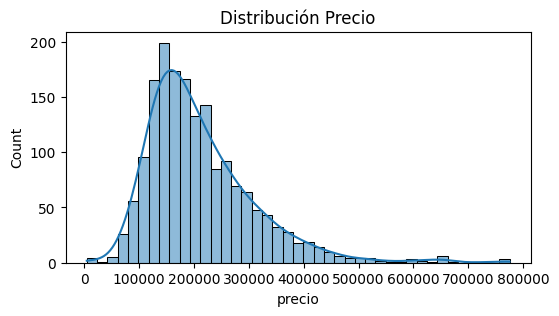

In [ ]:
# Distribución variable target
# Crea una figura y un eje (subplot) con un tamaño específico
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))

# Dibuja un histograma de la columna 'precio' del DataFrame 'datos',
# e incluye la curva de densidad (kde) sobre el histograma
sns.histplot(data=datos, x='precio', kde=True, ax=ax)

# Asigna un título al gráfico
ax.set_title("Distribución Precio")

# Asigna una etiqueta al eje x
ax.set_xlabel('precio')




### `fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))`

- **`plt.subplots(...)`**  
  Crea una nueva figura de Matplotlib y una cuadrícula de subgráficos (ejes). Devuelve:
  - `fig`: el objeto **Figure**, que representa toda la figura o "lienzo".
  - `ax`: el objeto **Axes**, que representa un único eje o gráfico (en este caso).

- **`nrows=1, ncols=1`**  
  Indica que la cuadrícula tendrá **1 fila y 1 columna**, es decir, se crea un solo gráfico.

- **`figsize=(6, 3)`**  
  Define el **tamaño de la figura** en pulgadas:  
  - 6 pulgadas de ancho  
  - 3 pulgadas de alto  
  *(1 pulgada = 2.54 cm, por lo tanto, aprox. 15.2 cm × 7.6 cm)*

Esta configuración se utiliza comúnmente como base para crear y personalizar gráficos utilizando el objeto `ax` (por ejemplo, `ax.plot()`, `ax.set_title()`, etc.).


## Distribución de las variables

Los modelos de redes neuronales son de tipo no paramétrico, no asumen ningún tipo de distribución de la variable respuesta, por lo tanto, no es necesario que esta siga ninguna distribución concreta (normal, gamma...). Aun así, siempre es recomendable hacer un estudio mínimo, ya que, a fin de cuentas, es lo que interesa predecir. En este caso, la variable precio tiene una distribución asimétrica con una cola positiva debido a que, unas pocas viviendas, tienen un precio muy superior a la media.


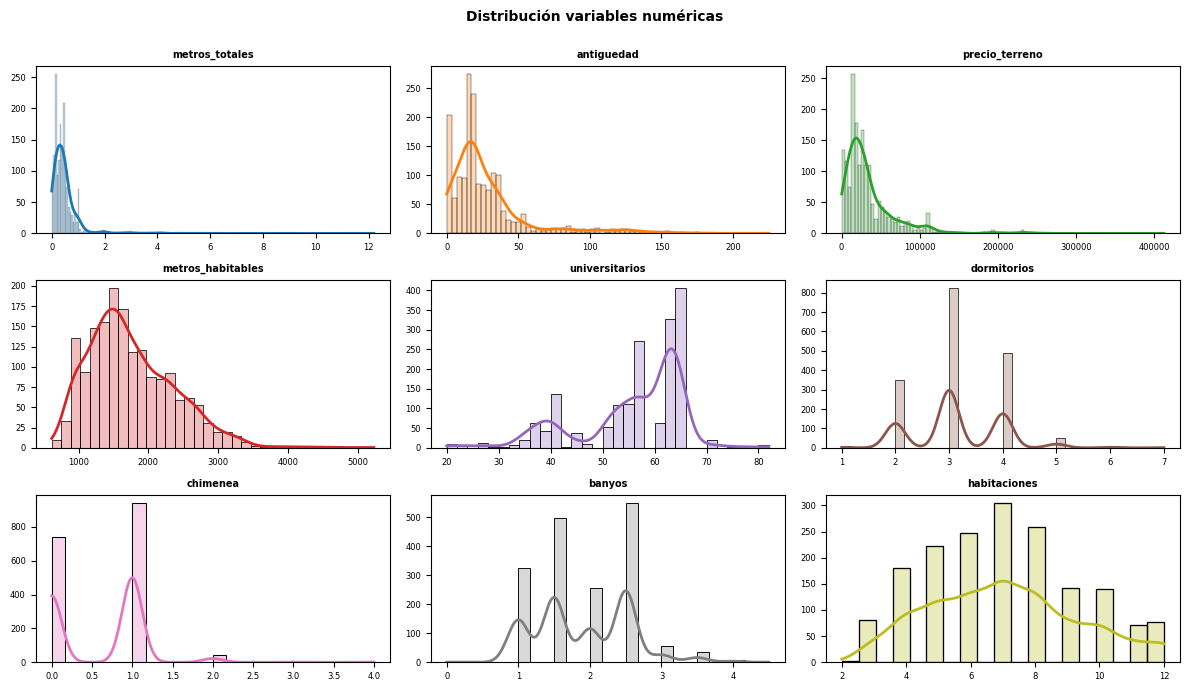

In [ ]:
# Obtenemos los nombres de las columnas numéricas
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
# y sacamos la de precio
columnas_numeric = columnas_numeric.drop('precio')


# Gráfico de distribución para cada variable numérica


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))
axes = axes.flat

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

La variable chimenea, aunque es de tipo numérico, apenas toma unos pocos valores y la gran mayoría de observaciones pertenecen a solo dos de ellos. En casos como este, suele ser conveniente tratar la variable como cualitativa.

In [ ]:
# Valores observados de chimenea
# Vamos a forzar a que la columna "chimenea" sea string, de modo que podamos manejarla como si fuera una variable categórica
datos.chimenea = datos.chimenea.astype("str")
datos.chimenea.value_counts()

,count
chimenea,
1,942
0,740
2,42
4,2
3,2


In [ ]:
# Variables categóricas (tipo object)
datos.select_dtypes(include=['object']).describe()

,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1728,1728,1728,1728,1728,1728,1728
unique,5,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,942,1121,1197,1213,1713,1647,1093


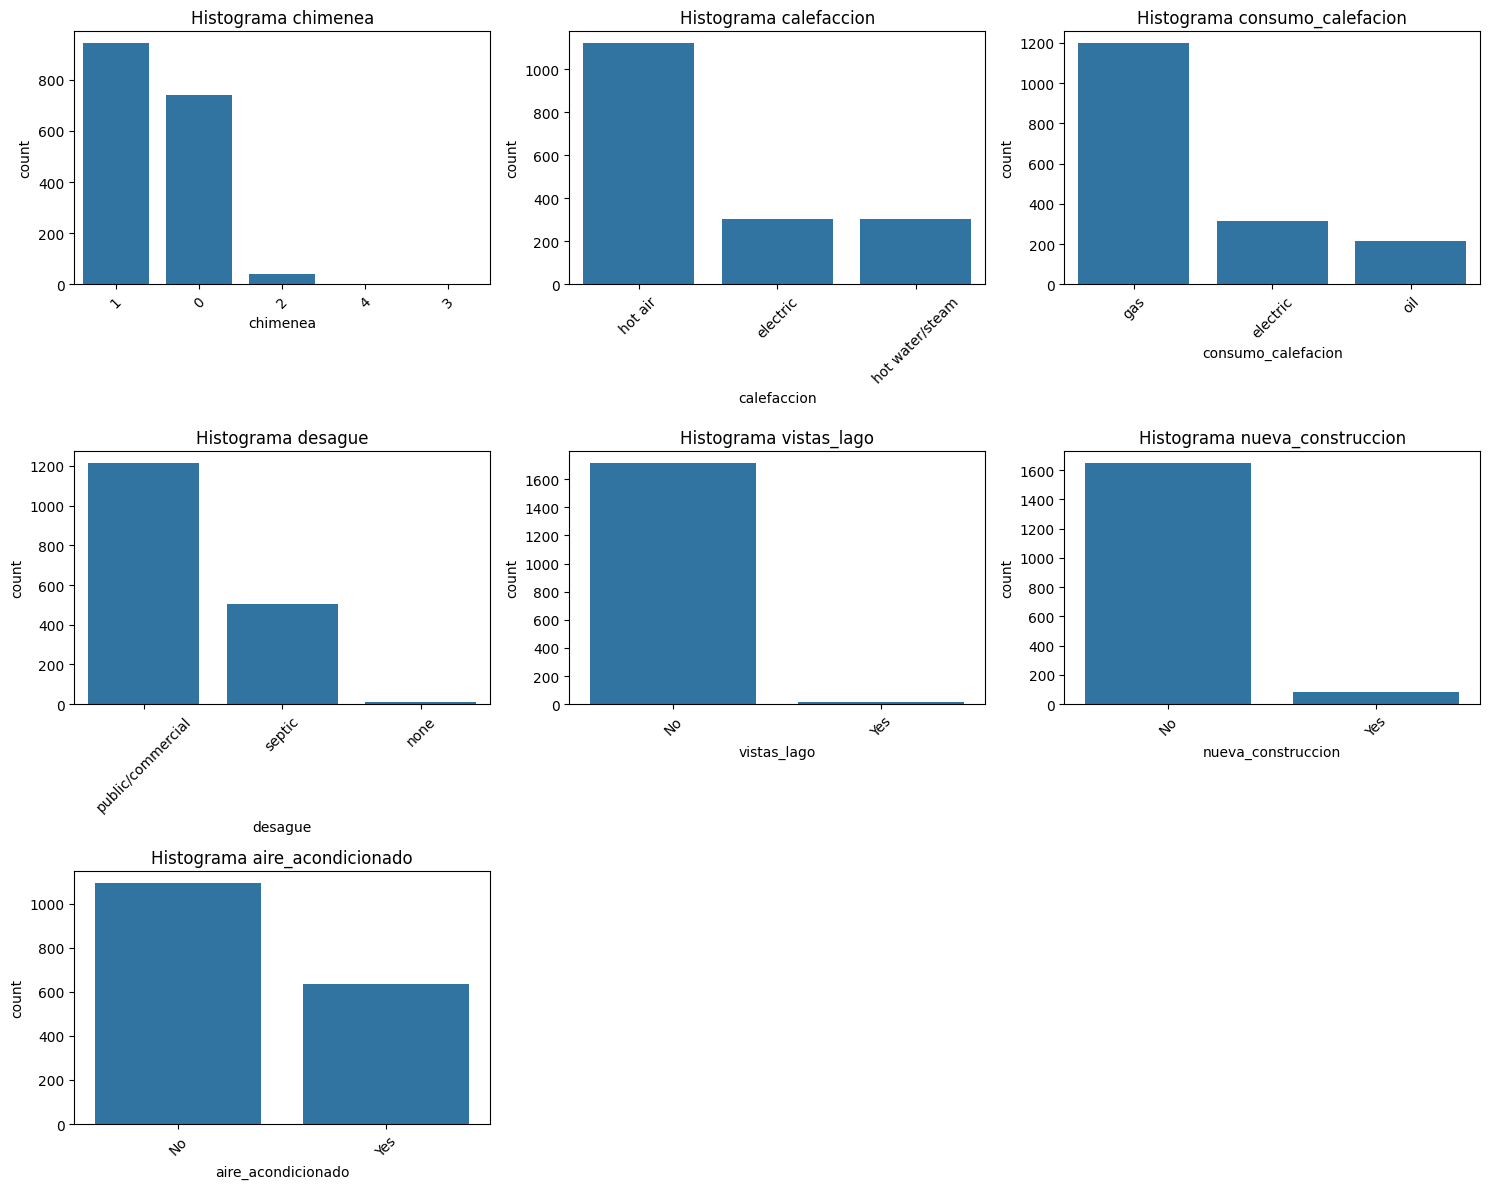

In [ ]:
# Gráfico para cada variable cualitativa
# ==============================================================================
columnas_object = datos.select_dtypes(include=['object']).columns

n_cols = 3
n_plots = len(columnas_object)
n_rows = math.ceil(n_plots / n_cols)

# Crear figura y ejes
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()  # para poder iterar fácilmente

# Graficar cada columna
for i, col in enumerate(columnas_object):
    sns.countplot(data=datos, x=col, ax=axes[i], order=datos[col].value_counts().index)
    axes[i].set_title(f'Histograma {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar ejes sobrantes (si los hay)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Si alguno de los niveles de una variable cualitativa tiene muy pocas observaciones en comparación a los otros niveles, puede ocurrir que, durante la validación cruzada o bootstrapping, algunas particiones no contengan ninguna observación de dicha clase (varianza cero), lo que puede dar lugar a errores. Para este caso, hay que tener precaución con la variable chimenea. Se unifican los niveles de 2, 3 y 4 en un nuevo nivel llamado "2_mas".

In [ ]:
dic_replace = {'2': "2_mas",
               '3': "2_mas",
               '4': "2_mas"}

datos['chimenea'] = datos['chimenea'].map(dic_replace).fillna(datos['chimenea'])
datos.chimenea.value_counts()

,count
chimenea,
1,942
0,740
2_mas,46


##División train y test


Con el objetivo de poder estimar el error que comete el modelo al predecir nuevas observaciones, se dividen los datos en dos grupos, uno de entrenamiento y otro de test (80%, 20%).

In [ ]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X = datos.drop('precio', axis = 'columns')
y = datos['precio']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8,
                                                    random_state = 42,
                                                    shuffle = True
                                                    )


Tras realizar el reparto, se verifica que los dos grupos son similares.

In [ ]:
print("Partición de entrenamento")
print("-----------------------")
display(y_train.describe())
display(X_train.describe())
display(X_train.describe(include = 'object'))
print(" ")

print("Partición de test")
print("-----------------------")
display(y_test.describe())
display(X_test.describe())
display(X_test.describe(include = 'object'))

Partición de entrenamento
-----------------------


,precio
count,1382.000000
mean,211229.997829
std,95803.220875
min,5000.000000
25%,145000.000000
50%,190000.000000
75%,256837.500000
max,775000.000000


,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,0.511216,28.374819,34564.377713,1753.793054,55.580318,3.157019,1.904124,7.043415
std,0.729205,29.956544,35340.845071,625.490273,10.279814,0.817498,0.662455,2.318173
min,0.000000,0.000000,200.000000,616.000000,20.000000,1.000000,1.000000,2.000000
25%,0.170000,13.000000,15100.000000,1300.250000,52.000000,3.000000,1.500000,5.000000
50%,0.370000,19.000000,25000.000000,1632.000000,57.000000,3.000000,2.000000,7.000000
75%,0.550000,34.000000,39675.000000,2127.250000,63.000000,4.000000,2.500000,8.000000
max,12.200000,225.000000,412600.000000,5228.000000,82.000000,7.000000,4.500000,12.000000


,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1382,1382,1382,1382,1382,1382,1382
unique,3,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,747,894,943,966,1369,1317,868


 
Partición de test
-----------------------


,precio
count,346.000000
mean,214909.277457
std,108439.961494
min,64500.000000
25%,148225.000000
50%,185000.000000
75%,260000.000000
max,775000.000000


,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,0.456272,26.083815,34528.468208,1759.699422,55.517341,3.144509,1.884393,7.034682
std,0.559175,25.974490,33763.864231,598.092016,10.560577,0.817870,0.642404,2.312903
min,0.000000,0.000000,300.000000,720.000000,23.000000,1.000000,0.000000,2.000000
25%,0.160000,13.000000,15100.000000,1293.000000,52.000000,3.000000,1.500000,5.000000
50%,0.370000,18.000000,25000.000000,1654.000000,57.000000,3.000000,2.000000,7.000000
75%,0.520000,33.000000,42850.000000,2207.500000,64.000000,4.000000,2.500000,9.000000
max,6.150000,165.000000,225800.000000,3968.000000,82.000000,6.000000,3.500000,12.000000


,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,346,346,346,346,346,346,346
unique,3,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,195,227,254,247,344,330,225


##Preprocesamiento


Los modelos de redes neuronales requieren como mínimo de dos tipos de preprocesamiento: One hot ecoding de las variables categóricas y estandarización de las variables continuas.

Si bien realizar el preprocesado de forma separada del entrenamiento es útil para explorar y confirmar que las transformaciones realizadas son las deseadas, en la práctica, es más adecuado asociarlo al propio proceso de entrenamiento. Esto puede hacerse fácilmente en los modelos de scikit-learn con los `Pipeline`.

##Modelado
###Pipepeline de preprocesado + modelado


En este tipo de problemas (que tiene predictores numéricos y categóricos) tenemos el inconveniente de que si queremos usar el modelo para predecir otras instancias debemos traducir sus valores al formato del encoding (por ejemplo las variables categóricas deberíamos expresarlas con su combinación correspondiente de ceros y unos).

Podríamos tener un pipeline de preprocesado (one-hot encoding y normalización) separado del entrenamiento del modelo, pero si queremos hacer grid search con cross validation será necesario un pipeline completo, es decir que contemple preprocesado + modelado.

In [ ]:
# Pipeline de preprocedado y modelado



# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPRegressor(solver = 'lbfgs', max_iter= 1000))])

In [ ]:
# Espacio de búsqueda de cada hiperparámetro para el grid search

param_distributions = {
    'modelo__hidden_layer_sizes': [(10), (20), (10,5), (10, 10)],
    'modelo__activation': ['logistic', 'relu'],
}

# Búsqueda por validación cruzada

grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = - 1,
        cv         = 5,
        random_state = 42,
        return_train_score = True
       )
# por parámetro scoring ver la discusión de https://scikit-learn.org/stable/modules/model_evaluation.html
grid.fit(X = X_train, y = y_train)

# Resultados de la búsqueda de los mejores hiperparámetros.
# Los mismos están contenidos en cv_results_

resultados = pd.DataFrame(grid.cv_results_)

resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_modelo__hidden_layer_sizes,param_modelo__activation,mean_test_score,std_test_score,mean_train_score,std_train_score
4,10,relu,-3.391124e+09,5.040963e+08,-2.360165e+09,3.304603e+08
7,"(10, 10)",relu,-3.828524e+09,6.935142e+08,-2.223907e+09,1.961863e+08
6,"(10, 5)",relu,-4.153092e+09,8.060726e+08,-2.116691e+09,1.883264e+08
5,20,relu,-5.082394e+09,1.247737e+09,-1.849335e+09,1.485408e+08
1,20,logistic,-7.733025e+09,2.139214e+09,-7.715925e+09,2.086155e+09
0,10,logistic,-8.634301e+09,9.835049e+08,-8.699753e+09,1.043132e+09
2,"(10, 5)",logistic,-8.914753e+09,1.013869e+09,-8.882915e+09,5.611051e+08
3,"(10, 10)",logistic,-9.196890e+09,7.204258e+08,-9.153867e+09,1.605753e+08


##Error en el conjunto reservado para testeo final

In [ ]:
# Error de test

# best_estimator_ es el "modelo" óptimo (configurado con los mejores hiperparámetros)
# que encontró el grid search

predicciones = grid.predict(X_test)
rmse = root_mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
       )
print('Error de test (rmse): ', rmse)

Error de test (rmse):  65747.82685473282


##Conclusión

La combinación de hiperparámetros con la que se obtienen mejores resultados acorde a las metricas de validación cruzada es:

In [ ]:
grid['modelo'].get_params()

TypeError: 'RandomizedSearchCV' object is not subscriptable